# Разведочный анализ утомленных лекцией

Пример анализа данных, полученных в рамках проектной деятельности с помощью онлайн-приложения "[Баланс внимания](http://balatte.stireac.com/)".


In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
smf = sm.formula
from statsmodels.stats.anova import anova_lm

Populating the interactive namespace from numpy and matplotlib


## Методика

1-й этап эксперимента:
-	Подготовка испытуемого и настрой на проведение контрольного теста. - 10 минут
-	Контрольный тест баланса внимания #1. - 5 минут - Тест в обычных условиях без физических и умственных нагрузок
-	Отдых. - 7 минут

2-й этап эксперимента:
-	Воздействие на испытуемого умственной нагрузкой, понижающей мотивацию, в виде просмотра видеозаписи  лекции на сложную и непонятную испытуемым тему ( лекция теории Марковских случайных процессов  https://www.youtube.com/watch?v=UveMw1SjEM4 )  - 15 минут. 
Контроль внимательности просмотра видео обеспечивается путем подсчета количества произношения разных форм слова  "процесс". (Например: процессом, процесса и т.д.) 
-	Тест баланса внимания #2. - 5 минут 


In [2]:
D = pd.read_table('d/rt9x2.tsv')
D

,t,v,isi,g,mod,subj,cond,nagr10
0,9.537,0.332,NaN,8.0,v,0,0,NaN
1,17.354,0.243,7.817,8.0,v,0,0,1.0
2,25.094,0.238,7.740,8.0,v,0,0,2.0
3,32.211,0.298,7.117,8.0,v,0,0,2.0
4,39.839,0.253,7.628,8.0,v,0,0,2.0
...,...,...,...,...,...,...,...,...
859,232.453,0.361,2.322,2.0,a,9,lect,4.0
860,234.724,0.298,2.271,2.0,a,9,lect,5.0
861,236.662,0.304,1.938,2.0,a,9,lect,5.0
862,239.017,0.309,2.355,2.0,a,9,lect,5.0


- t время предъявления стимула, с
- v время реакции, с
- isi межстимульный интервал (МСИ), с
- g режим стимуляции. В ходе тестирования МСИ задавался с небольшой вариацией в окрестности трех значений: 8, 4, 2 с.
8 - субъективно медленно, 4 - комфортно, 2 - часто.
Функциональное состояние изменялось от монотонии до активации
- mod модальность стимула visual - зрительный audial - слуховой
- subj идентификатор участника
- cond условие тестирования 0 - контроль, lect - после лекции
- nagr10 - "текущая нагрузка" - количество стимулов, требующих реакции, за последние 10 с.





Проверка полноты выборки необходима, чтобы при всех сочетаниях факторов объём данных был достаточным для статистики.
Проверка полноты выполняется путем подсчета значений в каждой группе.

In [3]:
D.groupby(['subj','cond','mod']).v.count()

subj  cond  mod
0     0     a      24
            v      24
      lect  a      24
            v      22
1     0     a      24
            v      23
      lect  a      24
            v      21
3     0     a      24
            v      24
      lect  a      24
            v      24
4     0     a      24
            v      23
      lect  a      24
            v      24
5     0     a      24
            v      23
      lect  a      24
            v      23
6     0     a      24
            v      21
      lect  a      24
            v      24
7     0     a      24
            v      23
      lect  a      19
            v      24
8     0     a      24
            v      24
      lect  a      24
            v      20
9     0     a      23
            v      24
      lect  a      24
            v      24
Name: v, dtype: int64

При группировке по нескольким колонкам на выходе получаем серию значений (pd.Series) со сложным индексом. У каждого значения в серии несколько указателей - по одному из каждой группирующей колонки.
По первому индексу `subj` понятно, что в тесте приняли участие 9 субъектов (респондентов).
В норме в каждой группе по 24 значения, но если были пропуски (значения отсутствуют), то в группе оказывается меньше значений.

Так как серия с количеством значений была на выходе последней команды, то к ней можно обратиться через специальное имя `_` (подчерк). Например, узнать в какой группе было больше всего пропусков, и, соответственно, меньше всего числовых значений.

In [4]:
_.argmin()

26

Строка в таблице для значения может быть, а само значение в этой строке отсутствовать.
В этом случае обычно на его месте ставят NaN (Not a Number).

In [5]:
D.v.isnull().sum()

23

Во всем наборе данных 23 пустых значения.

In [6]:
D.shape

(864, 8)

In [7]:
24 * 2 * 2 * 9  # n * mod * cond * subj

864

Таким образом, в таблице есть строчки для всех сочетаний факторов, но из-за пропусков реальных значений меньше. Анализ полноты повторных измерений (repeated measures) показал, что для каждого сочетания факторов было не менее 19 повторов.

## Анализ распределения зависимой переменной

Зависимая переменная `v` - ВР, с.

Перед тем, как применять методы параметрической статистики нужно убедиться, что значения варьируют близко к нормальному распределению.

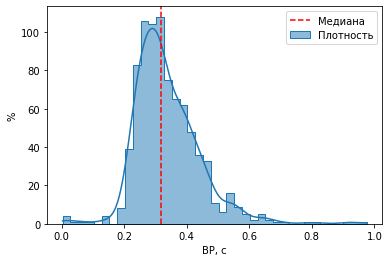

In [4]:
sns.histplot(D.v.dropna(), kde=True, element="step", label='Плотность');
axvline(D.v.median(),c='r',ls='--', label='Медиана');
xlabel('ВР, с')
ylabel('%')
legend();

Распределение имеет четко выраженную центральную тенденцию - один "горб" посередине и плавно убывающие "хвосты" по бокам.
Левый фронт более крутой - распределение асимметрично со сдвигом вправо. 
Для введения в модель степени асимметричности нужен еще один параметр, однако такое усложнение потребует специальных методов статистического анализа.
В данном случае выгоднее пренебречь небольшим отклонением от нормальности в виде асимметрии, но при этом воспользоваться хорошо разработанным математическим аппаратом вариационной статистики.

Чтобы не влияли редкие значения, попавшие в хвосты распределения, "обрежем" его в тех границах, где плотность подходит к нулю.

In [10]:
X = D[(D.v>=.18)&(D.v<.72)]

В этом распределены смешаны данные, полученные при разных условиях и модальности стимулов. Сопоставим групповые выборки с помощью разных типов графиков.

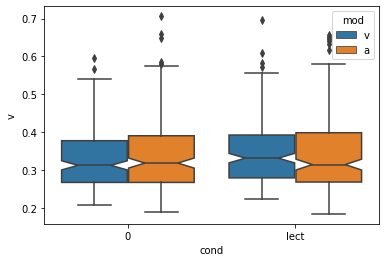

In [11]:
sns.boxplot(x='cond', y='v', hue='mod', data=X, notch=True);

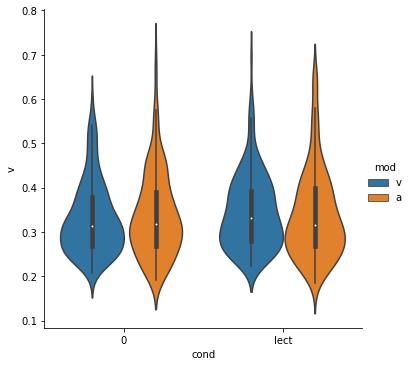

In [12]:
sns.catplot(x='cond', y='v', hue='mod', data=X, kind='violin');

## Вариационный анализ

Семейство статистических методов, оценивающих возможности объяснить дисперсию (вариацию) в целевом (зависимом) показателе за счет вариации объясняющих (независимых) показателей, называют дисперсионный анализ или анализ вариации. 
В названии конкретных методов часто встречается аббревиатура ANOVA (ANalysis Of VAriation). Основы дисперсионного анализа были разработаны Р. Фишером.

При записи формулы многофакторных моделей объясняющие факторы записывают как части суммы, а если еще учитывают их совместное (сочетанное) действие, то как множители произведения.

$$v \sim Cond*Mod$$

В процессе анализа основное внимание сосредоточим на действии фактора "условие" (cond), при этом разделяя реакции на стимулы разных модальностей (mod) - зрительные и слуховые, - потому что зрительное и слуховое внимание работают на основе разных механизмов.

Проведем многофакторный вариационный анализ для повторных измерений с помощью пакета statmodels.



In [13]:
mo = smf.mixedlm('v ~ cond*mod', data=X, groups='subj').fit()
mo.summary()

c:\a\winpython\python-3.9.0rc1.amd64\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM    Dependent Variable:    v        
No. Observations:    824        Method:                REML     
No. Groups:          9          Scale:                 0.0045   
Min. group size:     88         Log-Likelihood:        1023.8836
Max. group size:     95         Converged:             Yes      
Mean group size:     91.6                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.339    0.022 15.444 0.000  0.296  0.382
cond[T.lect]           0.002    0.007  0.316 0.752 -0.011  0.015
mod[T.v]              -0.009    0.007 -1.305 0.192 -0.021  0.004
cond[T.lect]:mod[T.v]  0.011    0.009  1.143 0.253 -0.008  0.029
subj Var               0.004    0.031                           
================================================================

"""

Значения ВР в с слишком маленькие, и алгоритм подбора параметров модели выдает предупреждение о сходимости (ConvergenceWarning).

Попробуем перевести значения в мс и запустим еще раз.


In [14]:
D['rtms'] = D.v * 1000
X = D[(D.v>=.18)&(D.v<.72)]
mo = smf.mixedlm('rtms ~ cond*mod', data=X, groups='subj').fit()
mo.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM     Dependent Variable:     rtms      
No. Observations:     824         Method:                 REML      
No. Groups:           9           Scale:                  4496.2534 
Min. group size:      88          Log-Likelihood:         -4640.4757
Max. group size:      95          Converged:              Yes       
Mean group size:      91.6                                          
--------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              338.706   21.932 15.444 0.000 295.721 381.691
cond[T.lect]             2.075    6.563  0.316 0.752 -10.789  14.938
mod[T.v]                -8.560    6.562 -1.305 0.192 -21.421   4.300
cond[T.lect]:mod[T.v]   10.693    9.352  1.143 0.253  -7.636  29.021
subj Var              4138.924   31.394                             
====================================================================

"""

В таблице результатов надо смотреть колонку `P>|z|` - это и есть p-value, вероятность того, что влияние факторов случайно. Действие фактора расценивается существенным, если p-значение меньше 0.05.

Если не учитывать ритм подачи стимулов, то различия не обнаруживаются.

## Распределения с учетом МСИ

Если мы хотим сопоставить на одном рисунке несколько распределений, то вместо классических гистограмм, которые будут закрывать друг друга при наложении, можно использовать графики оценки плотности ядра (KDE - kernel density estimation).

График оценки плотности ядра (KDE) - это метод визуализации
распределения наблюдений в наборе данных, аналогичный гистограмме. KDE
представляет данные с использованием непрерывной кривой плотности вероятности.

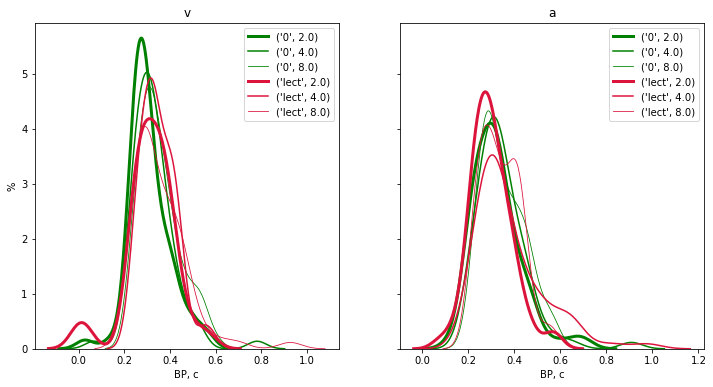

In [18]:
g_lw = {2:3, 4:1.5, 8:0.8}
co_cond = {'0':'green', 'lect':'crimson'}

fig,ax = subplots(1,2, sharey=True, figsize=(12,6))

for i,modality in enumerate(['v','a']):
    sca(ax[i])
    title(modality)
    
    g=D[D['mod']==modality].groupby(['cond','g'])
    for k in sorted(g.groups.keys()):
        vv = g.get_group(k).v.dropna()
        cond,gr = k
        sns.kdeplot(vv, label=k, color=co_cond[cond], lw=g_lw[gr]);
    xlabel('ВР, с')
    ylabel('%')
    legend();

Фактор `g`  - группа влияет достоверно, но как именно? 
И у всех ли испытуемых однонаправленно?

## Анализ на R

Статистики исторически любят работать в среде языка R, поэтому самые свежие версии алгоритмов анализа могут быть доступны в виде библиотек на R.
Если на компьютере установлен бесплатный пакет R, то тут же в блокноте можно провести анализ.
Для этого надо загрузить расширение для подключения R.
```
%load_ext rpy2.ipython
```

После этого, если ячейка начинается со специальной команды `%%R`, то код в ней обрабатывается не в Python, а в R. Например, импорт библиотек на языке R осуществляется командой library, а не import.
```
%%R 
library(car)
library(lme4)
```

Для анализа нужно передать в среду R наш набор данных, который мы указываем после ключа `-i` - input вход.
```py
%%R -i X

(m1 <- lmer(v ~ cond*mod*g + (1|subj), data = X))
Anova(m1, test.statistic="F")
```

На выходе получаем результат в виде текста:
```
Analysis of Deviance Table (Type II Wald F tests with Kenward-Roger df)

Response: v
                 F Df Df.res    Pr(>F)    
cond        2.5504  1 808.01    0.1107    
mod         0.5121  1 808.03    0.4745    
g          19.7105  1 808.02 1.026e-05 ***
cond:mod    1.5166  1 808.02    0.2185    
cond:g      1.8920  1 808.01    0.1694    
mod:g       0.6344  1 808.01    0.4260    
cond:mod:g  0.4963  1 808.02    0.4813    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

Значимость влияния фактора в результатах анализа помечены кодами - звёздочками. Чем больше звездочек, тем больше значимость.

Сопоставив средние ВР для трех МСИ, мы можем понять, что ВР при увеличении МСИ растет. В данном случае взаимодействие фактора `g` с другими не выявлено.

Чтобы оценить форму зависимости при разных сочетаниях уровней факторов, выведем график зависимости для каждого респондента.

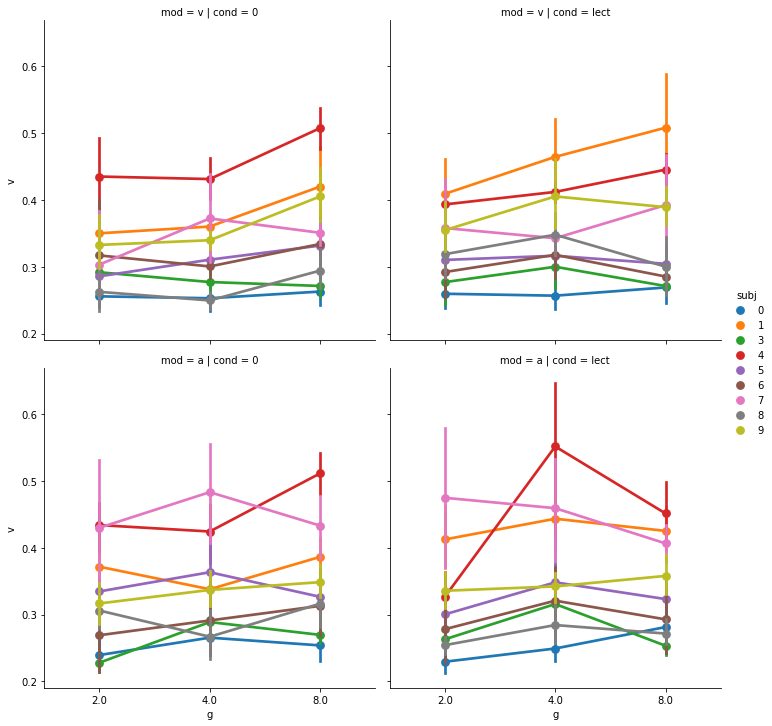

In [17]:
h = sns.catplot(x='g', y='v', hue='subj', col='cond', row='mod', data=X, 
                   kind='point', alpha=0.5);

На одном рисунке мы визуализировали зависимости ВР от МСИ для каждой группы модальности/условия/испытуемого.
